In [1]:
import numpy as np
from scipy.io import loadmat
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import clear_output
import imageio
import os

from kan import *
from use_training_set import *

## Load training set

In [2]:
import yaml

# Parameters to save
params = {
    "mat_filename_grid": "./training_sets/fg/SQ_grid_fg.mat",
    "mat_filename_rand": "./training_sets/fg/SQ_rand_fg.mat",
    "index_parameters": "(parameters_list[:,2]<=20)*(parameters_list[:,0]<=0.405)*(parameters_list[:,0]>=0.03)",
    "exp_scale": 2,
    "outliers_threshold": 3
}

# Save parameters to a YAML file
with open('setup_ts.txt', 'w') as file:
    yaml.dump(params, file)

In [3]:
config_file = 'setup_ts.txt'
x_train, y_train, Q_train = load_training_data(config_file)

parameters shape: (13000, 3)
SQ shape: (13000, 95)
parameters mean: [ 0.2175  0.26   10.5   ]
parameters std: [0.1125     0.14422205 5.7662813 ]
Q shape: (95,)
Outliers are at indices: (array([15409]), array([0]))


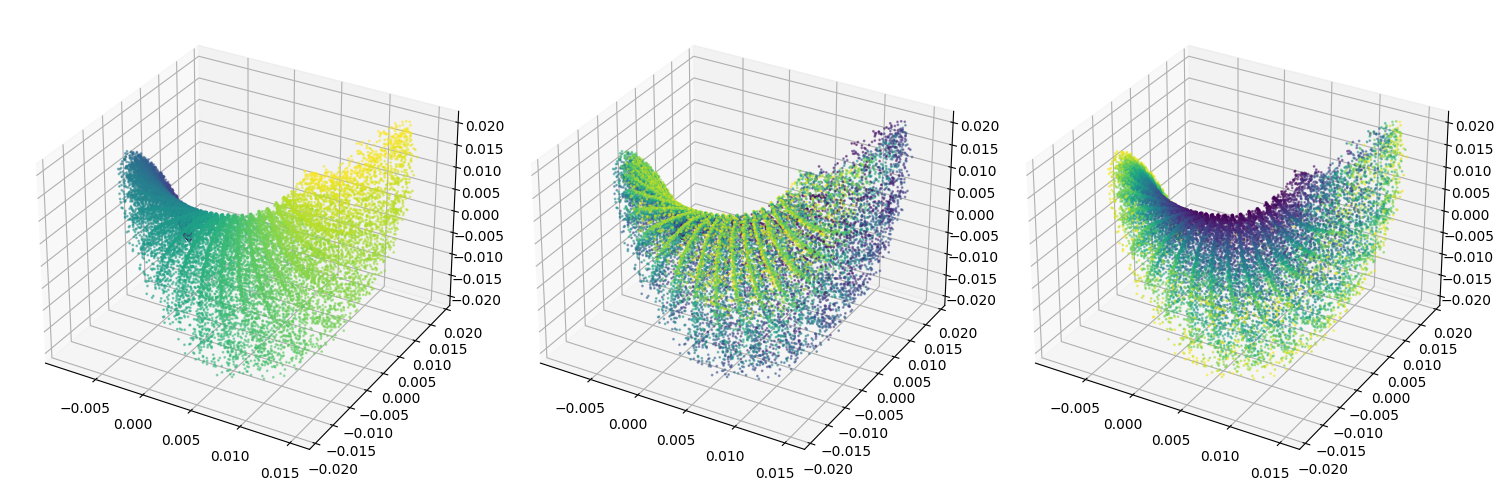

In [4]:
# Perform SVD
y_train_ave = np.mean(y_train, axis=0)
y_train_centered = y_train - y_train_ave
U, S, Vt = np.linalg.svd(y_train_centered, full_matrices=False)

# Get the first 3 principal components
PC = U[:, :3]

# Create a 3D plot
fig = plt.figure(figsize=(15, 5))
colormap = plt.cm.get_cmap('viridis')  # or any other colormap you like

for i in range(3):
    # Create a colormap based on x_train
    colors = colormap((x_train[:,i]-np.min(x_train[:,i]))/(np.max(x_train[:,i])-np.min(x_train[:,i])))

    ax = fig.add_subplot(1,3,i+1, projection='3d')
    ax.scatter(PC[:, 0], PC[:, 1], PC[:, 2], c=colors, s=1, alpha=0.5)

plt.tight_layout()
plt.show()

In [5]:
# y_train = np.log(y_train)

# Add a column of ones to x to account for the bias term
x_train_bias = np.hstack([x_train, np.ones((x_train.shape[0], 1))])

# Initialize A and B
A = np.zeros((x_train.shape[1], y_train.shape[1]))
B = np.zeros(y_train.shape[1])

# For each target variable
for i in range(y_train.shape[1]):
    # Solve for A and B using least squares
    coef, _, _, _ = np.linalg.lstsq(x_train_bias, y_train[:, i], rcond=None)
    A[:, i] = coef[:-1]
    B[i] = coef[-1]

## Define model

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# cpu = torch.device('cpu')
# device = cpu
torch.set_default_dtype(torch.float32)

cuda


In [7]:
def calculate_output_size(input_size, filter_size, padding, stride):
    return int((input_size - filter_size + 2*padding) / stride + 1)

def to_torch(array):
    return torch.from_numpy(array).float()

cuda0 = torch.device('cuda:0')
cpu = torch.device('cpu')
def to_torch_device(array,device=device):
    return torch.from_numpy(array.astype('float32')).float().to(device)

In [8]:
## define KAN model
Q = np.linspace(1.2,20,95)
class SQ_KAN(nn.Module):
    def __init__(self, width=[4,11,1], width_aug=[3,7,7,3], grid=10, grid_aug=10, k=3, seed=42, device=device, multiplier=2):
        super(SQ_KAN, self).__init__()
        self.kan_aug = KAN(width=width_aug, grid=grid_aug, k=k, seed=seed, device=device, noise_scale=1)#, base_fun = 'identity')
        self.kan = KAN(width=width, grid=grid, k=k, seed=seed, device=device, noise_scale=1, base_fun = 'identity')
        self.kan_aug.update_grid_from_samples(to_torch_device(x_train))
        self.Q_torch_scale = to_torch_device((Q-6)/20)
        self.Q_torch = to_torch_device(Q)
        self.A = to_torch_device(A)
        self.B = to_torch_device(B)
        self.multiplier = multiplier
        
    def forward(self, x):
        # bg = (x@self.A+self.B)
        phi = x[:,0]
        x = self.kan_aug(x)
        x_expanded = x.unsqueeze(1).expand(-1, self.Q_torch_scale.size(0), -1)
        Q_expanded = self.Q_torch_scale.unsqueeze(0).unsqueeze(-1).expand(x.size(0), -1, x.size(-1))
        Q_params = torch.cat([Q_expanded, x_expanded], dim=-1)
        Q_params_reshaped = Q_params.view(-1, Q_params.size(-1))
        # self.kan.update_grid_from_samples(Q_params_reshaped)
        G_full = self.kan(Q_params_reshaped)
        G_full_reshaped = G_full.view(x.size(0), self.Q_torch_scale.size(0))
        phi_expanded = phi.unsqueeze(1).expand_as(G_full_reshaped)
        
        # Compute alpha, beta, and gama
        alpha = (1 + 2 * phi)**2 / (1 - phi)**4
        beta = -6 * phi * (1 + phi / 2)**2 / (1 - phi)**4
        gama = phi * alpha / 2
        
        # Compute G_hs(Q,phi)
        Q_torch = self.Q_torch.unsqueeze(0).expand(x.size(0), -1)
        alpha_expanded = alpha.unsqueeze(1).expand_as(Q_torch)
        beta_expanded = beta.unsqueeze(1).expand_as(Q_torch)
        gama_expanded = gama.unsqueeze(1).expand_as(Q_torch)
        
        G_hs = (alpha_expanded * (torch.sin(Q_torch) - Q_torch * torch.cos(Q_torch)) / Q_torch**2 +
                beta_expanded * (2 * Q_torch * torch.sin(Q_torch) + (2 - Q_torch**2) * torch.cos(Q_torch) - 2) / Q_torch**3 +
                gama_expanded * (-Q_torch**4 * torch.cos(Q_torch) + 4 * ((3 * Q_torch**2 - 6) * torch.cos(Q_torch) +
                (Q_torch**3 - 6 * Q_torch) * torch.sin(Q_torch) + 6)) / Q_torch**5)
        
        # Ensure G_hs has the shape (n_sample, n_Q)
        G_hs = G_hs.view(x.size(0), self.Q_torch.size(0))
        
        return 1/(self.multiplier*phi_expanded*(G_full_reshaped+G_hs)/self.Q_torch + 1)
    
model_KAN = SQ_KAN(width=[4,9,1], width_aug=[3,7,3], grid=7, grid_aug=15, k=3, seed=11451419, device=device)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


## Train KAN

In [9]:
def visualize_training_KAN(model, epoch, loss_list, x_ind, y_ind, save_path, savefig=True):
    os.makedirs(save_path, exist_ok=True)
    
    bg = (x_ind@to_torch_device(A)+to_torch_device(B)).detach().cpu().numpy()
    y_pred_ind = model(x_ind)
    clear_output(wait=True)
    plt.figure(figsize=(11.5, 8))  # adjust the size as needed
    gs = gridspec.GridSpec(3, 4, width_ratios=[1, 1, 1, 2])

    for i in range(9):
        ax = plt.subplot(gs[i//3, i%3])
        length_y = y_ind.shape[1]
        q = Q
        y_train_plot = (y_ind[i].detach().cpu().numpy())
        y_pred_plot = (y_pred_ind[i].detach().cpu().numpy())
        ax.plot(q,y_train_plot, label='True')
        ax.plot(q,y_pred_plot, label='Predicted')
        ax.set_xlim([-0.5,20.5])
        ax.set_ylim([0,3.5])
        ax.set_xlabel(r'$QD$')
        ax.set_ylabel(r'$S(QD)$')
        ax.set_aspect(20/3.5)  # Set aspect ratio to 1

    # Add a subplot for the training loss
    ax_loss = plt.subplot(gs[:, 3])
    ax_loss.plot(loss_list, label='Training loss')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.set_yscale('log')
    ax_loss.legend()
    
    # Get the current x and y limits
    x_range = ax_loss.get_xlim()
    y_range = ax_loss.get_ylim()

    # Calculate the ranges
    x_span = x_range[1] - x_range[0]
    y_span = np.log10(y_range[1]) - np.log10(y_range[0])

    # Set the aspect ratio
    if x_span > y_span:
        ratio = x_span / y_span
        ax_loss.set_aspect(ratio)
    else:
        ratio = y_span / x_span
        ax_loss.set_aspect(1.0 / ratio)

    plt.suptitle(f'Epoch {epoch}, Loss: {loss_list[-1]}')
    plt.tight_layout()
    
    # Save the figure to a file
    if epoch % 200 == 0:
        if savefig:
            plt.savefig(os.path.join(save_path, f'epoch_{epoch:04d}.png'))
        
    plt.show()
    plt.pause(0.001)

def train_model_KAN(model, x_train, y_train, epochs=100, batch_size=256, lr=1e-3, savefig=True):
    # Convert numpy arrays to PyTorch tensors
    x_train_torch = to_torch_device(x_train)
    y_train_torch = to_torch_device(y_train)

    # Create a DataLoader
    dataset = TensorDataset(x_train_torch, y_train_torch)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Define a loss function
    criterion = nn.MSELoss()
    # criterion = nn.HuberLoss()

    # Define an optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # optimizer = optim.SGD(model.parameters(), lr=lr)
    
    # Randomly pick 9 indices for plotting
    np.random.seed(114514)
    indices = np.random.choice(len(y_train), size=12, replace=False)

    lost_list = []
    for epoch in range(epochs):
        for x_batch, y_batch in dataloader:
            # Forward pass: compute predicted y by passing x to the model
            y_pred = model(x_batch)

            # Compute and print loss
            index_loss = np.random.randint(95, size=36)
            loss = criterion(y_pred[:,index_loss], y_batch[:,index_loss])

            # Zero gradients, perform a backward pass, and update the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        lost_list.append(loss.item())

        # Plot the selected curves
        save_path="./figures/KAN/"
        if epoch == 0:
            # Remove all files in the save_path directory
            for filename in os.listdir(save_path):
                file_path = os.path.join(save_path, filename)
                try:
                    if os.path.isfile(file_path) or os.path.islink(file_path):
                        os.unlink(file_path)
                except Exception as e:
                    print('Failed to delete %s. Reason: %s' % (file_path, e))
        if epoch % 1 == 0:
            # Print loss for this epoch
            # print(f'Epoch {epoch}, Loss: {loss.item()}')
            
            visualize_training_KAN(model, epoch, lost_list, x_train_torch[indices], y_train_torch[indices], save_path, savefig=savefig)
            # plt.figure(figsize=(6, 4))
            # plt.plot(lost_list)
            # plt.xlabel('Epoch')
            # plt.ylabel('Loss')
            # plt.yscale('log')
            # # plt.xscale('log')
            # plt.show()
            
        # if epoch % 10 == 0:
            model.kan_aug.plot(scale=1)
            model.kan.plot(scale=1)

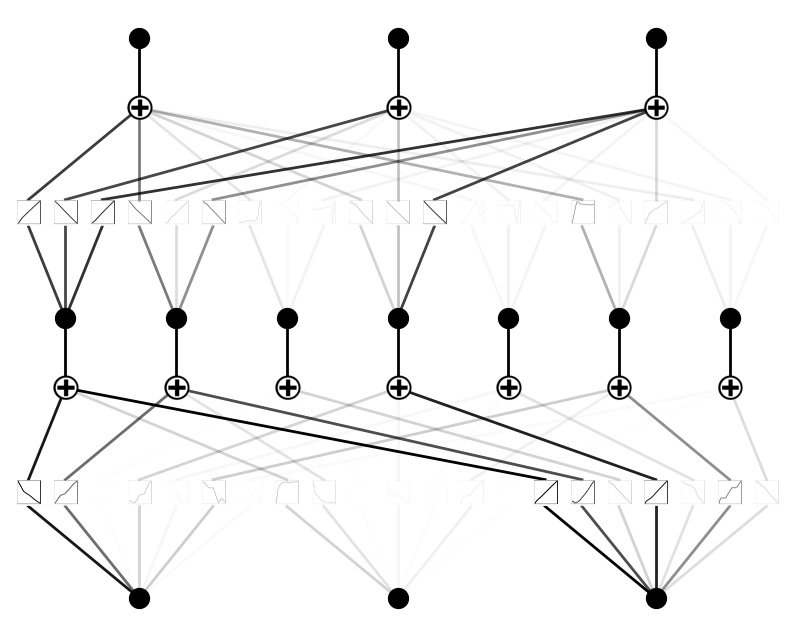

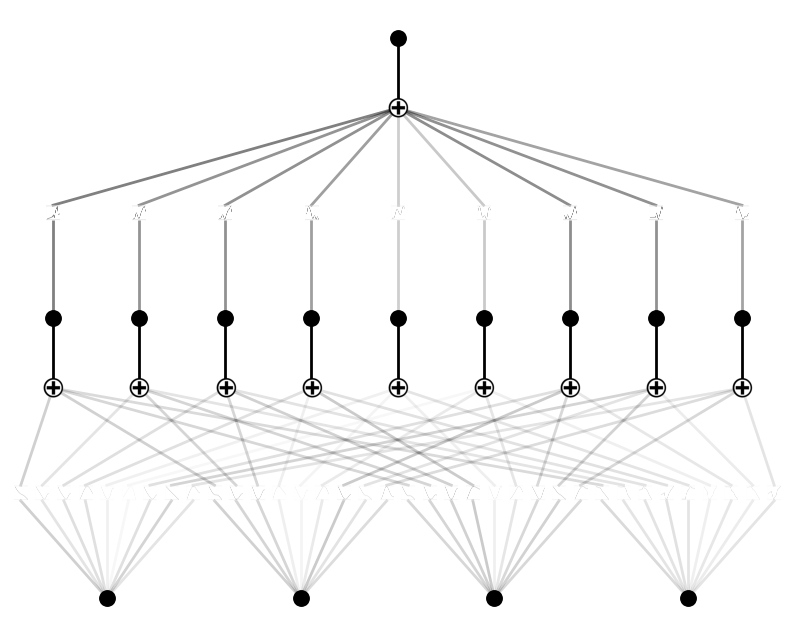

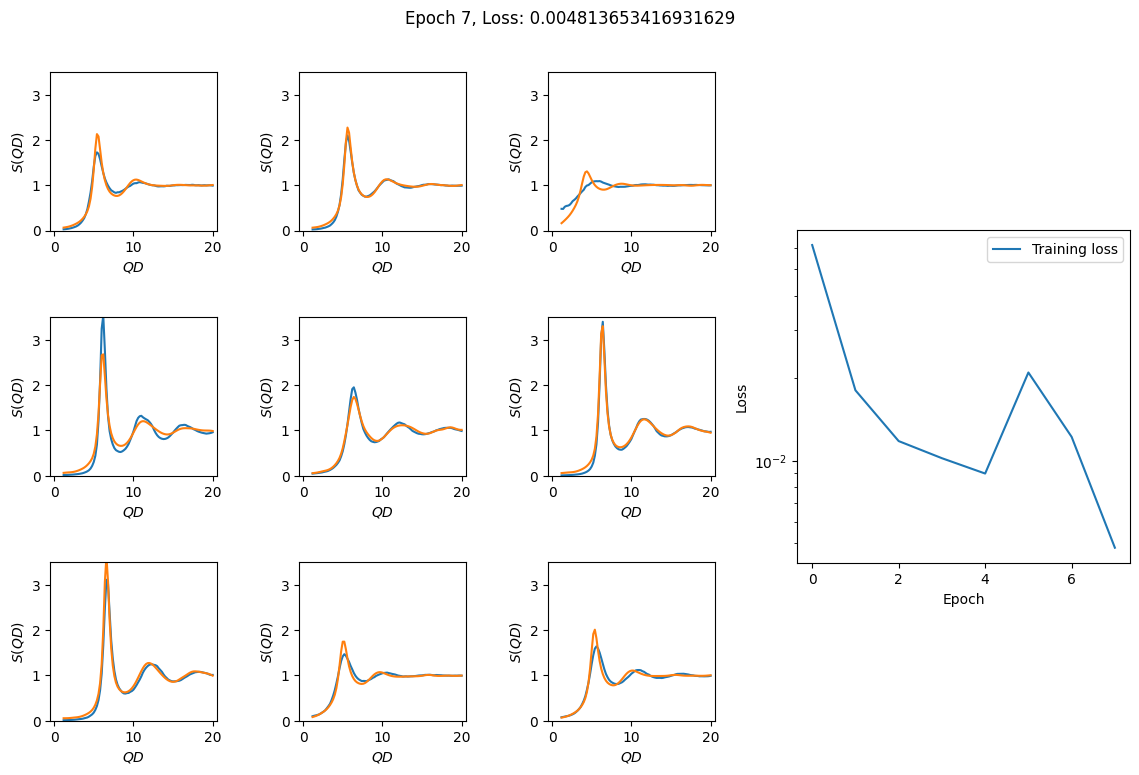

In [10]:
# model_KAN.load_state_dict(torch.load('./saved_model/KAN/model_7_7_grid.pth'))
train_model_KAN(model_KAN, x_train, y_train, epochs=100, batch_size=256, lr=5e-3)

In [14]:
torch.save(model_KAN.state_dict(), './saved_model/KAN/model_7_9_grid.pth')

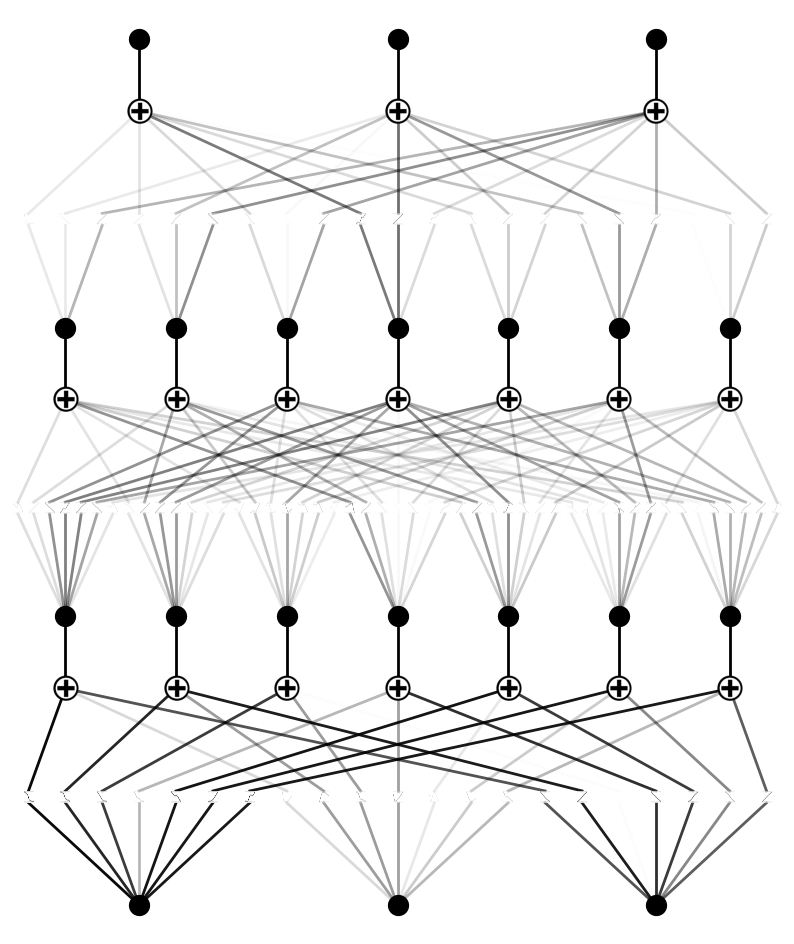

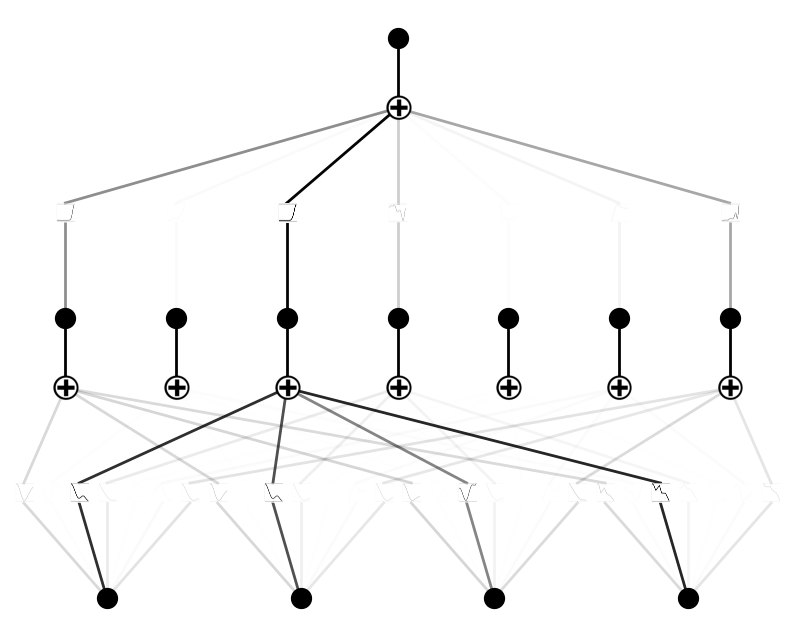

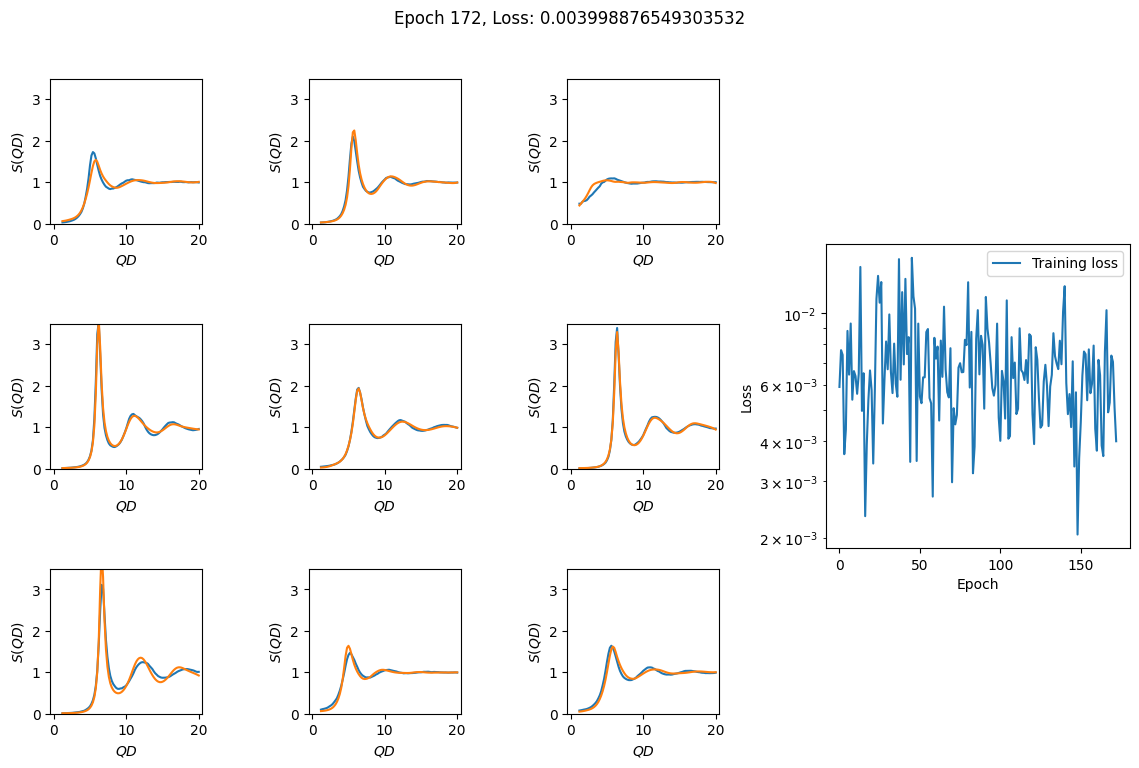

KeyboardInterrupt: 

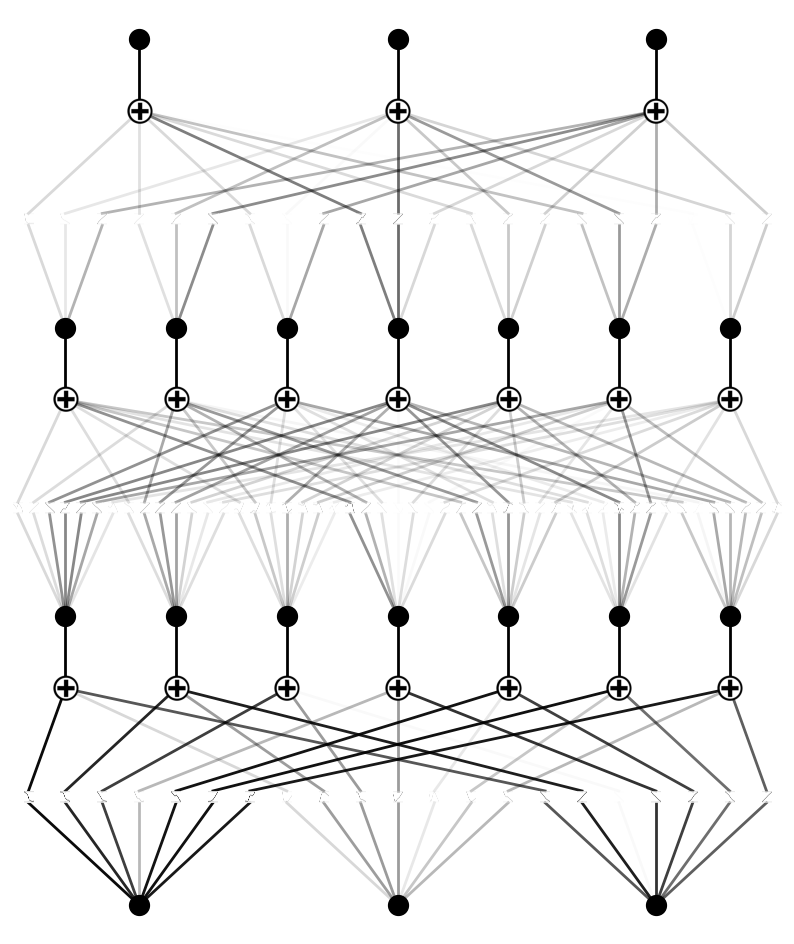

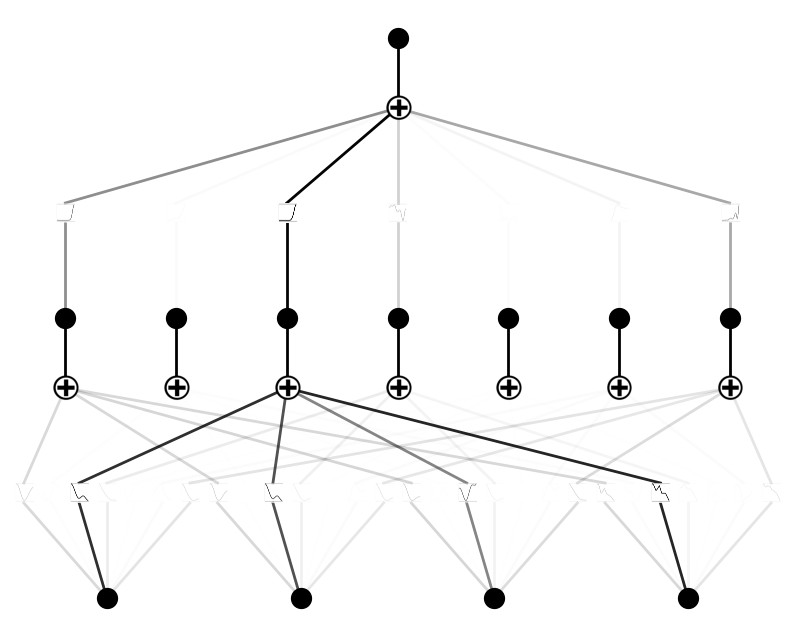

In [15]:
model_KAN.load_state_dict(torch.load('./saved_model/KAN/model_7_9_grid.pth'))
train_model_KAN(model_KAN, x_train, y_train, epochs=1000, batch_size=128, lr=1e-3)

In [23]:
fneme = "./saved_model/KAN/model_7_9_grid_ft.pth"
torch.save(model_KAN.state_dict(), fneme)